Features: train (5091, 512), val (1285, 512) in 47.0s
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best MLP params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (512, 256, 128), 'learning_rate_init': 0.001, 'solver': 'adam'} F1 (cv): 0.7695133486196705
Best validation F1=0.8541 at threshold=0.52

--- TRAIN ---
Accuracy : 0.9719
Precision: 0.9692
Recall   : 0.9782
F1-score : 0.9737


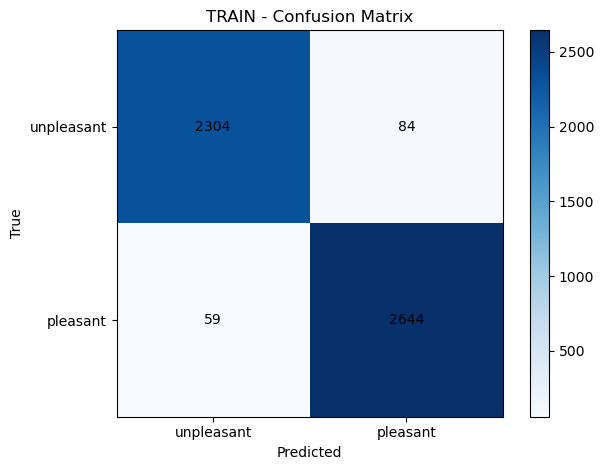

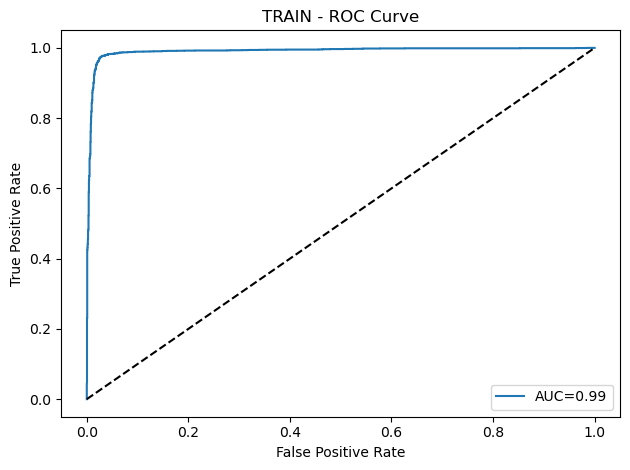


--- VALIDATION ---
Accuracy : 0.8397
Precision: 0.8363
Recall   : 0.8726
F1-score : 0.8541


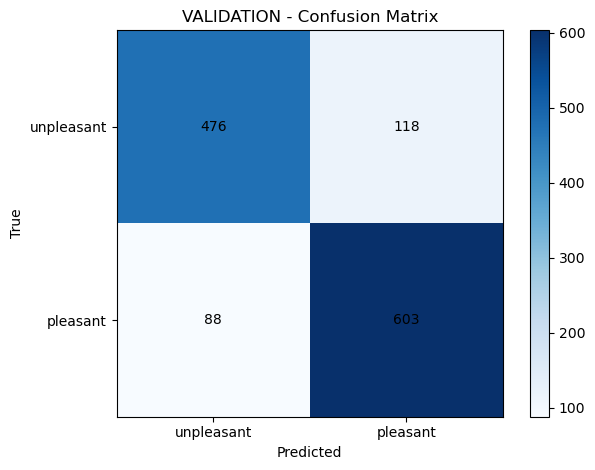

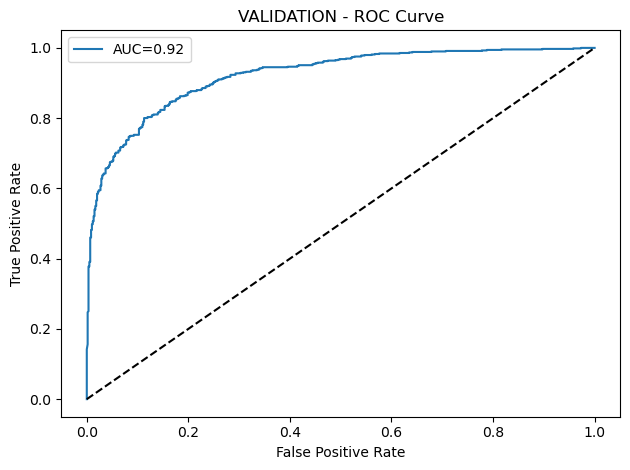


Saved submission to submission_mlp.csv


In [4]:
import os
import random
import time
import warnings

warnings.filterwarnings('ignore')  # suppress warnings 

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)

# ---------- 1. Paths & settings -----------------------------------
TRAIN_DIR   = r"/Users/nicoletatour/Desktop/train-images/train"
TEST_DIR    = r"/Users/nicoletatour/Desktop/TEST_images/TEST_images"
IDS_CSV     = r"/Users/nicoletatour/Desktop/Test-IDs.csv"  # CSV mapping filenames to IDs
OUT_CSV     = "submission_mlp.csv"

# set random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# class labels mapping
LABELS = {'unpleasant': 0, 'pleasant': 1}

# ---------- 2. Image transforms ----------------------------------
IMG_SIZE = 64

# augmentations for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# only resize & normalize for evaluation
eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- 3. Feature extractor: ResNet-18 -----------------------
backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
backbone.fc = nn.Identity()    # remove final fully-connected layer
backbone.to(device).eval()     # set to evaluation mode

# freeze all parameters
for param in backbone.parameters():
    param.requires_grad = False

# ---------- 4. Dataset & feature extraction ---------------------
class ImageDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths  = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.transform(img), self.labels[idx]

def extract_features(paths, transform, batch_size=32):
    """
    Pass images through the frozen CNN to get feature vectors.
    Returns a numpy array of shape (N, feature_dim).
    """
    ds = ImageDataset(paths, [0]*len(paths), transform)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False)
    feats = []
    with torch.no_grad():
        for imgs, _ in dl:
            imgs = imgs.to(device)
            out  = backbone(imgs)           # shape (batch_size, feature_dim)
            feats.append(out.cpu().numpy())
    return np.vstack(feats)

# ---------- 5. Plotting helpers ----------------------------------
def plot_confusion_matrix(cm, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{title} - Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['unpleasant', 'pleasant'])
    plt.yticks(ticks, ['unpleasant', 'pleasant'])
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"{title} - ROC Curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 6. Evaluation function -------------------------------
def evaluate(name, X, y, model, threshold):
    """
    Compute metrics and display confusion matrix and ROC curve.
    """
    y_probs = model.predict_proba(X)[:,1]
    y_pred  = (y_probs >= threshold).astype(int)
    print(f"\n--- {name} ---")
    print(f"Accuracy : {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall   : {recall_score(y, y_pred):.4f}")
    print(f"F1-score : {f1_score(y, y_pred):.4f}")
    cm = confusion_matrix(y, y_pred)
    plot_confusion_matrix(cm, name)
    plot_roc_curve(y, y_probs, name)


# ------- 7. Load training file paths & labels -----------------------

pairs = []
for cls, lbl in LABELS.items():
    cls_dir = os.path.join(TRAIN_DIR, cls)
    for fn in os.listdir(cls_dir):
        if fn.lower().endswith(('.png','.jpg','.jpeg')):
            pairs.append((os.path.join(cls_dir, fn), lbl))
paths, labels = zip(*pairs)
paths = np.array(paths)
y     = np.array(labels)

# ------- 8. Subject-level split to avoid leakage ----------------------

subjects  = np.array([os.path.basename(p).split('_')[0] for p in paths])
uniq_subj = np.unique(subjects)
train_s, val_s = train_test_split(uniq_subj, test_size=0.2, random_state=SEED)
train_idx = [i for i,s in enumerate(subjects) if s in train_s]
val_idx   = [i for i,s in enumerate(subjects) if s in val_s]

train_paths, train_labels = paths[train_idx], y[train_idx]
val_paths,   val_labels   = paths[val_idx],   y[val_idx]

# ------ 9. Extract features for train & validation --------------------

start = time.time()
X_train = extract_features(train_paths, train_transform)
X_val   = extract_features(val_paths,   eval_transform)
print(f"Features: train {X_train.shape}, val {X_val.shape} in {time.time()-start:.1f}s")

# ------- 10. Standardize features --------------------------------------

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

# -------- 11. Hyperparameter tuning with GridSearchCV -------------------

param_grid = {
    'hidden_layer_sizes': [(512,256,128)],
    'activation':         ['relu','tanh'],
    'solver':             ['adam','sgd'],
    'alpha':              [1e-2,1e-3],
    'learning_rate_init': [1e-4,1e-3]
}
base = MLPClassifier(
    max_iter=300, early_stopping=True,
    n_iter_no_change=10, random_state=SEED
)
grid = GridSearchCV(
    base, param_grid, scoring='f1',
    cv=3, n_jobs=-1, verbose=2
)
grid.fit(X_train, train_labels)
print("Best MLP params:", grid.best_params_, "F1 (cv):", grid.best_score_)
mlp = grid.best_estimator_

# -------- 12. Threshold tuning on validation -----------------------------

y_val_probs = mlp.predict_proba(X_val)[:,1]
best_thr, best_f1 = 0.5, 0
for thr in np.linspace(0.1,0.9,81):
    f1 = f1_score(val_labels, (y_val_probs>=thr).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"Best validation F1={best_f1:.4f} at threshold={best_thr:.2f}")

# evaluate train & validation with chosen threshold
evaluate("TRAIN",      X_train, train_labels, mlp, best_thr)
evaluate("VALIDATION", X_val,   val_labels,   mlp, best_thr)

# -------- 13. Final test set prediction & submission --------------------

test_files = sorted([
    f for f in os.listdir(TEST_DIR)
    if f.lower().endswith(('.png','.jpg','.jpeg'))
])
test_paths = [os.path.join(TEST_DIR, f) for f in test_files]

# load mapping from Filename to ID
id_df = pd.read_csv(IDS_CSV)
if {'Filename','ID'}.issubset(id_df.columns):
    id_map = dict(zip(id_df['Filename'], id_df['ID']))
    ids = [id_map[f] for f in test_files]
else:
    ids = id_df['ID'].tolist()

# extract features & predict
X_test     = scaler.transform(extract_features(test_paths, eval_transform))
probs_test = mlp.predict_proba(X_test)[:,1]
preds_test = (probs_test >= best_thr).astype(int)

# write submission CSV with columns ID,LABEL
with open(OUT_CSV, 'w') as f:
    f.write('ID,LABEL\n')
    for id_val, pred in zip(ids, preds_test):
        f.write(f"{id_val},{pred}\n")

print(f"\nSaved submission to {OUT_CSV}")
